In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

In [13]:
# File paths
metadata_path = '/kaggle/input/metadata-csv/HAM10000_metadata.csv'
handcrafted_feature_path = '/kaggle/input/features/features.csv'

In [14]:
def map_to_binary(label):
    """Map HAM10000 labels to binary: 1 (melanoma), 0 (non-melanoma)."""
    return 1 if label == 'mel' else 0

def plot_roc_curve(y_test, y_pred_proba, feature_set_name, clf_name):
    """Plot and save individual ROC curve."""
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {feature_set_name} - {clf_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/{feature_set_name}_{clf_name}_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.close()

def plot_combined_roc_curves(results_dict, y_test, feature_set_name):
    """Plot combined ROC curves for all classifiers."""
    plt.figure(figsize=(12, 8))
    colors = ['darkorange', 'green', 'red', 'purple', 'brown']
    
    for i, (clf_name, result_data) in enumerate(results_dict.items()):
        y_pred_proba = result_data['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, 
                label=f'{clf_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Combined ROC Curves - {feature_set_name}')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'results/{feature_set_name}_combined_roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_feature_importance(model, feature_names, feature_set_name, clf_name):
    """Plot and save feature importance for tree-based models."""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)[::-1]
        
        # Show top 15 features for handcrafted features (since we have 33 total)
        n_top = min(15, len(feature_names))
        top_features = feature_names[sorted_idx[:n_top]]
        top_importance = importance[sorted_idx[:n_top]]
        
        plt.figure(figsize=(10, 8))
        sns.barplot(x=top_importance, y=top_features, palette='viridis')
        plt.title(f'Top {n_top} Feature Importance - {feature_set_name} - {clf_name}')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.savefig(f'results/{feature_set_name}_{clf_name}_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.close()

In [ ]:
def evaluate_handcrafted_features(handcrafted_path, metadata_path, classifiers, feature_set_name='handcrafted_33'):
    """
    Evaluate handcrafted features with data augmentation and comprehensive analysis.
    
    Parameters:
    - handcrafted_path (str): Path to hand-crafted features CSV.
    - metadata_path (str): Path to HAM10000_metadata.csv.
    - classifiers (dict): Dictionary of classifiers and parameter grids.
    - feature_set_name (str): Name for output files.
    
    Returns:
    - dict: Performance metrics for each classifier.
    
    """
    # Load data
    handcrafted_df = pd.read_csv(handcrafted_path)
    metadata_df = pd.read_csv(metadata_path)
    
    # Merge features and labels
    data = handcrafted_df.merge(metadata_df[['image_id', 'dx']], on='image_id')
    data['label'] = data['dx'].apply(map_to_binary)
    
    # Prepare features and labels
    X = data.drop(['image_id', 'dx', 'label'], axis=1)
    y = data['label']
    
    print(f"Handcrafted features shape: {X.shape}")
    print(f"Feature names: {list(X.columns)}")
    print(f"Class distribution before augmentation:\n{y.value_counts()}")
    print(f"Class distribution percentages:\n{y.value_counts(normalize=True) * 100}")
    
    if len(y) == 0:
        raise ValueError("No samples after merging. Check data alignment.")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Data augmentation: Add Gaussian noise to minority class samples in training set
    minority_class = 1
    majority_count = sum(y_train == 0)
    minority_count = sum(y_train == 1)
    samples_to_add = majority_count - minority_count
    
    print(f"Training set - Majority class: {majority_count}, Minority class: {minority_count}")
    print(f"Adding {samples_to_add} synthetic samples for minority class")
    
    minority_mask = y_train == minority_class
    minority_X = X_train[minority_mask]
    
    augmented_X = []
    augmented_y = []
    noise_level = 0.01  # Small noise level to avoid distorting features
    
    for _ in range(samples_to_add):
        sample_idx = np.random.choice(len(minority_X))
        sample = minority_X.iloc[sample_idx].copy()
        noise = np.random.normal(0, noise_level * sample.std(), sample.shape)
        augmented_sample = sample + noise
        augmented_X.append(augmented_sample)
        augmented_y.append(minority_class)
    
    if augmented_X:
        augmented_X_df = pd.DataFrame(augmented_X, columns=X_train.columns)
        augmented_y_series = pd.Series(augmented_y)
        
        X_train_aug = pd.concat([X_train, augmented_X_df], ignore_index=True)
        y_train_aug = pd.concat([y_train, augmented_y_series], ignore_index=True)
    else:
        X_train_aug = X_train
        y_train_aug = y_train
    
    print(f"Class distribution after augmentation:\n{y_train_aug.value_counts()}")
    
    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_aug)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Feature scaling completed. Training set shape: {X_train_scaled.shape}")
    
    results = {}
    roc_data = {}
    
    for clf_name, (clf, param_grid) in classifiers.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {clf_name} for {feature_set_name}...")
        print(f"{'='*50}")
        
        # Use fewer CV folds for SVM to speed up training
        cv_folds = 3 if clf_name != 'SVM' else 2
        
        grid_search = GridSearchCV(clf, param_grid, 
                                 cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42), 
                                 scoring='f1_weighted', n_jobs=-1, verbose=1)
        
        print(f"Starting grid search with {cv_folds}-fold CV...")
        grid_search.fit(X_train_scaled, y_train_aug)
        best_clf = grid_search.best_estimator_
        
        print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")
        
        # Predict and evaluate
        y_pred = best_clf.predict(X_test_scaled)
        y_pred_proba = best_clf.predict_proba(X_test_scaled)[:, 1]
        report = classification_report(y_test, y_pred, target_names=['Non-Melanoma', 'Melanoma'], output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store ROC data for combined plot
        roc_data[clf_name] = {'y_pred_proba': y_pred_proba}
        
        # Save outputs
        os.makedirs('results', exist_ok=True)
        
        # Save classification report
        with open(f'results/{feature_set_name}_{clf_name}_report.txt', 'w') as f:
            f.write(f"Classification Report - {feature_set_name} - {clf_name}\n")
            f.write("="*60 + "\n")
            f.write(f"Best Parameters: {grid_search.best_params_}\n")
            f.write(f"Best CV Score: {grid_search.best_score_:.4f}\n\n")
            f.write(classification_report(y_test, y_pred, target_names=['Non-Melanoma', 'Melanoma']))
        
        # Plot and save confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Non-Melanoma', 'Melanoma'], 
                   yticklabels=['Non-Melanoma', 'Melanoma'])
        plt.title(f'Confusion Matrix - {feature_set_name} - {clf_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'results/{feature_set_name}_{clf_name}_cm.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Plot individual ROC curve
        plot_roc_curve(y_test, y_pred_proba, feature_set_name, clf_name)
        
        # Plot feature importance for applicable models
        if clf_name in ['RF', 'XGBoost', 'LightGBM']:
            plot_feature_importance(best_clf, X.columns, feature_set_name, clf_name)
        
        # Store metrics
        results[clf_name] = {
            'accuracy': report['accuracy'],
            'f1_score': report['weighted avg']['f1-score'],
            'roc_auc': roc_auc,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'best_params': grid_search.best_params_,
            'cv_score': grid_search.best_score_
        }
        
        print(f"Results - Accuracy: {report['accuracy']:.4f}, "
              f"F1-Score: {report['weighted avg']['f1-score']:.4f}, "
              f"ROC-AUC: {roc_auc:.4f}")
        print(f"Precision: {report['weighted avg']['precision']:.4f}, "
              f"Recall: {report['weighted avg']['recall']:.4f}")
    
    # Plot combined ROC curves
    print(f"\n{'='*50}")
    print(f"Creating combined ROC curve for {feature_set_name}...")
    print(f"{'='*50}")
    plot_combined_roc_curves(roc_data, y_test, feature_set_name)
    
    return results

In [16]:
# Calculate class weights for imbalanced data handling
pos_weight_estimate = 8  # Approximately 8:1 ratio from your data

# Define all classifiers
classifiers = {
    'SVM': (SVC(probability=True, random_state=42, class_weight='balanced'), {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }),
    'RF': (RandomForestClassifier(random_state=42, class_weight='balanced'), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }),
    'XGBoost': (xgb.XGBClassifier(
        random_state=42,
        scale_pos_weight=pos_weight_estimate,
        eval_metric='logloss'
    ), {
        'n_estimators': [200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 0.9]
    }),
    'LightGBM': (lgb.LGBMClassifier(
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ), {
        'n_estimators': [200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'num_leaves': [31, 50]
    })
}

print("Starting evaluation of 33 handcrafted features...")
print(f"Using classifiers: {list(classifiers.keys())}")
print("="*80)

Starting evaluation of 33 handcrafted features...
Using classifiers: ['SVM', 'KNN', 'RF', 'XGBoost', 'LightGBM']


Handcrafted features shape: (10015, 33)
Feature names: ['area', 'perimeter', 'circularity', 'aspect_ratio', 'compactness', 'diameter', 'eccentricity', 'solidity', 'extent', 'equivalent_diameter', 'contrast', 'correlation', 'energy', 'homogeneity', 'dissimilarity', 'asm', 'entropy_glcm', 'lbp_mean', 'lbp_variance', 'edge_density', 'mean_r', 'mean_g', 'mean_b', 'var_r', 'var_g', 'var_b', 'std_grayscale', 'skewness_grayscale', 'kurtosis_grayscale', 'color_entropy', 'fractal_dimension', 'asymmetry_index', 'perimeter_to_area']
Class distribution before augmentation:
label
0    8902
1    1113
Name: count, dtype: int64
Class distribution percentages:
label
0    88.88667
1    11.11333
Name: proportion, dtype: float64
Training set - Majority class: 7122, Minority class: 890
Adding 6232 synthetic samples for minority class
Class distribution after augmentation:
0    7122
1    7122
Name: count, dtype: int64
Feature scaling completed. Training set shape: (14244, 33)

Evaluating SVM for handcrafted

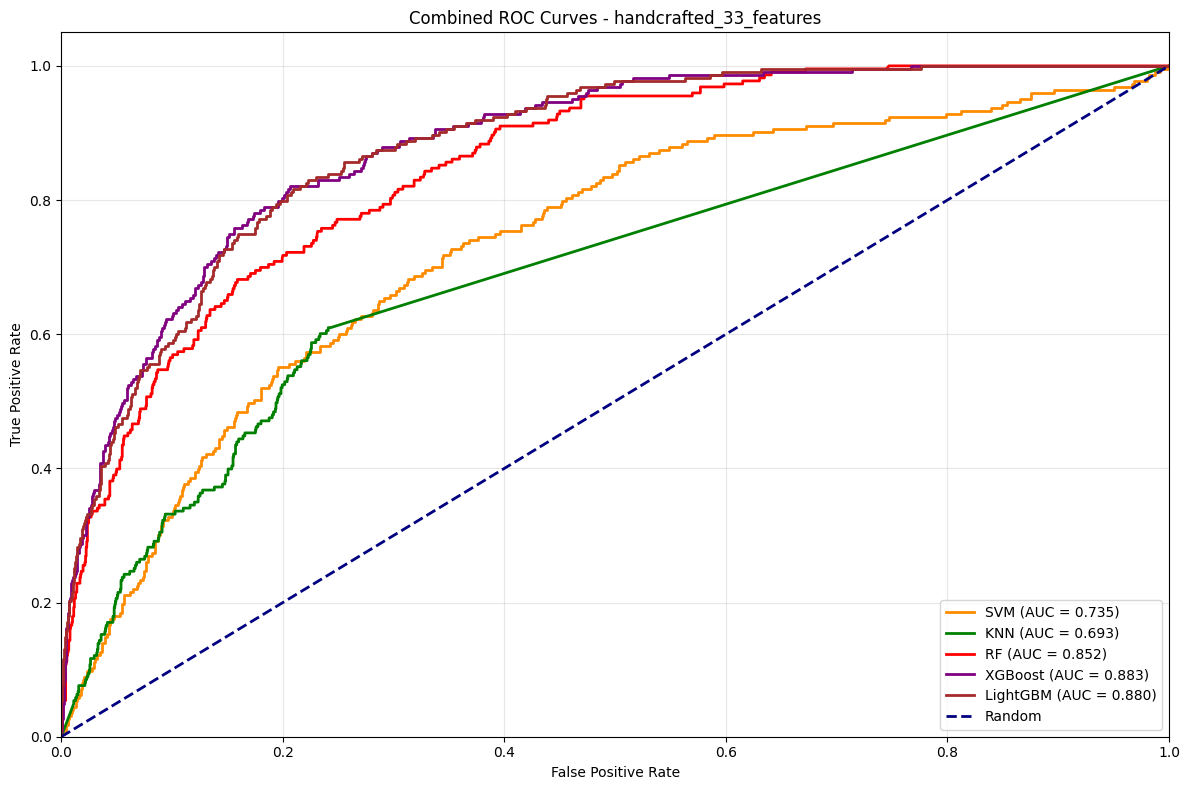


FINAL RESULTS SUMMARY - 33 HANDCRAFTED FEATURES
               Feature_Set Classifier  Accuracy  F1_Score  ROC_AUC  Precision  \
0  33 Handcrafted Features        SVM    0.8877    0.8367   0.7348     0.8178   
1  33 Handcrafted Features        KNN    0.8627    0.8526   0.6931     0.8448   
2  33 Handcrafted Features         RF    0.8987    0.8683   0.8519     0.8816   
3  33 Handcrafted Features    XGBoost    0.8987    0.8941   0.8826     0.8909   
4  33 Handcrafted Features   LightGBM    0.9066    0.8908   0.8803     0.8920   

   Recall  CV_Score  
0  0.8877    0.9091  
1  0.8627    0.8455  
2  0.8987    0.9411  
3  0.8987    0.9423  
4  0.9066    0.9446  


In [17]:
# Run evaluation
feature_set_name = 'handcrafted_33_features'
results = evaluate_handcrafted_features(handcrafted_feature_path, metadata_path, classifiers, feature_set_name)

# Collect results for analysis
all_results = []
for clf_name, metrics in results.items():
    all_results.append({
        'Feature_Set': '33 Handcrafted Features',
        'Classifier': clf_name,
        'Accuracy': metrics['accuracy'],
        'F1_Score': metrics['f1_score'],
        'ROC_AUC': metrics['roc_auc'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'CV_Score': metrics['cv_score']
    })

# Create summary DataFrame
summary_df = pd.DataFrame(all_results)

print(f"\n{'='*80}")
print("FINAL RESULTS SUMMARY - 33 HANDCRAFTED FEATURES")
print(f"{'='*80}")
print(summary_df.round(4))

In [ ]:
# Save all results in a single zip file for download
import zipfile

# Define the results directory
results_dir = 'results'

# Create a zip file containing all results
with zipfile.ZipFile('results/all_results_handcrafted.zip', 'w') as zipf:
    for root, _, files in os.walk(results_dir):
        for file in files:
            if file != 'all_results_handcrafted.zip':  # Avoid zipping the zip file itself
                zipf.write(os.path.join(root, file), arcname=file)

print("All results have been zipped into 'results/all_results_handcrafted.zip' for download.")

All results have been zipped into 'results/all_results_handcrafted.zip' for download.
